# Trabajo numero 3 para DH

---

Vamos a trabajar con un dataset de S-PLUS,  cada fila corresponde a una galaxia observada por S-PLUS y cada columna de nombre '... *_petro' de la tabla son las magnitudes integradas observadas por S-PLUS dentro de un radio de Petrosian en las 12 bandas fotometricas de S-PLUS. La ultima columna es el redshift espectroscopico dado para cada galaxia por el Sloan Digital Sky Survey (SDSS). Entonces, a partir de las 12 columnas fotometricas vamos a calcular el redshift fotometrico.
Esto lo vamos a resolver a travez de 3 metodos de ML: Regrecion Lineal (usando OLS),


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



import warnings # supress warnings
warnings.filterwarnings('ignore')



df = pd.read_csv('splus-mag-z.dat', sep='\s+')
df.head()

ModuleNotFoundError: No module named 'xgboost'

In [122]:
df.describe()

uJAVA_petro    F378_petro    F395_petro    F410_petro    F430_petro  \
count  55803.000000  55803.000000  55803.000000  55803.000000  55803.000000   
mean      20.027314     19.776800     19.621324     19.431730     19.178868   
std        1.353688      1.323287      1.366704      1.363994      1.361901   
min        9.860000      9.530000      9.430000      8.120000      8.140000   
25%       19.320000     19.100000     18.910000     18.740000     18.490000   
50%       20.040000     19.800000     19.640000     19.470000     19.240000   
75%       20.760000     20.500000     20.370000     20.190000     19.970000   
max       31.020000     28.690000     29.160000     28.800000     29.130000   

            g_petro    F515_petro       r_petro    F660_petro       i_petro  \
count  55803.000000  55803.000000  55803.000000  55803.000000  55803.000000   
mean      18.650515     18.357072     17.899382     17.776786     17.557151   
std        1.249274      1.262739      1.195358      1.202301      1.196353   
min        7.010000      7.020000      6.390000      6.180000      6.230000   
25%       18.000000     17.700000     17.260000     17.120000     16.890000   
50%       18.720000     18.420000     17.990000     17.870000     17.660000   
75%       19.450000     19.170000     18.760000     18.650000     18.430000   
max       25.070000     25.060000     21.040000     21.110000     21.180000   

         F861_petro       z_petro        z_SDSS  
count  55803.000000  55803.000000  55803.000000  
mean      17.395165     17.358351      0.148431  
std        1.226137      1.226402      0.095942  
min        5.580000      6.050000      0.002000  
25%       16.710000     16.660000      0.080000  
50%       17.500000     17.460000      0.131000  
75%       18.290000     18.260000      0.190000  
max       22.570000     21.600000      1.124000

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55803 entries, 0 to 55802
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uJAVA_petro  55803 non-null  float64
 1   F378_petro   55803 non-null  float64
 2   F395_petro   55803 non-null  float64
 3   F410_petro   55803 non-null  float64
 4   F430_petro   55803 non-null  float64
 5   g_petro      55803 non-null  float64
 6   F515_petro   55803 non-null  float64
 7   r_petro      55803 non-null  float64
 8   F660_petro   55803 non-null  float64
 9   i_petro      55803 non-null  float64
 10  F861_petro   55803 non-null  float64
 11  z_petro      55803 non-null  float64
 12  z_SDSS       55803 non-null  float64
dtypes: float64(13)
memory usage: 5.5 MB


# Some plots

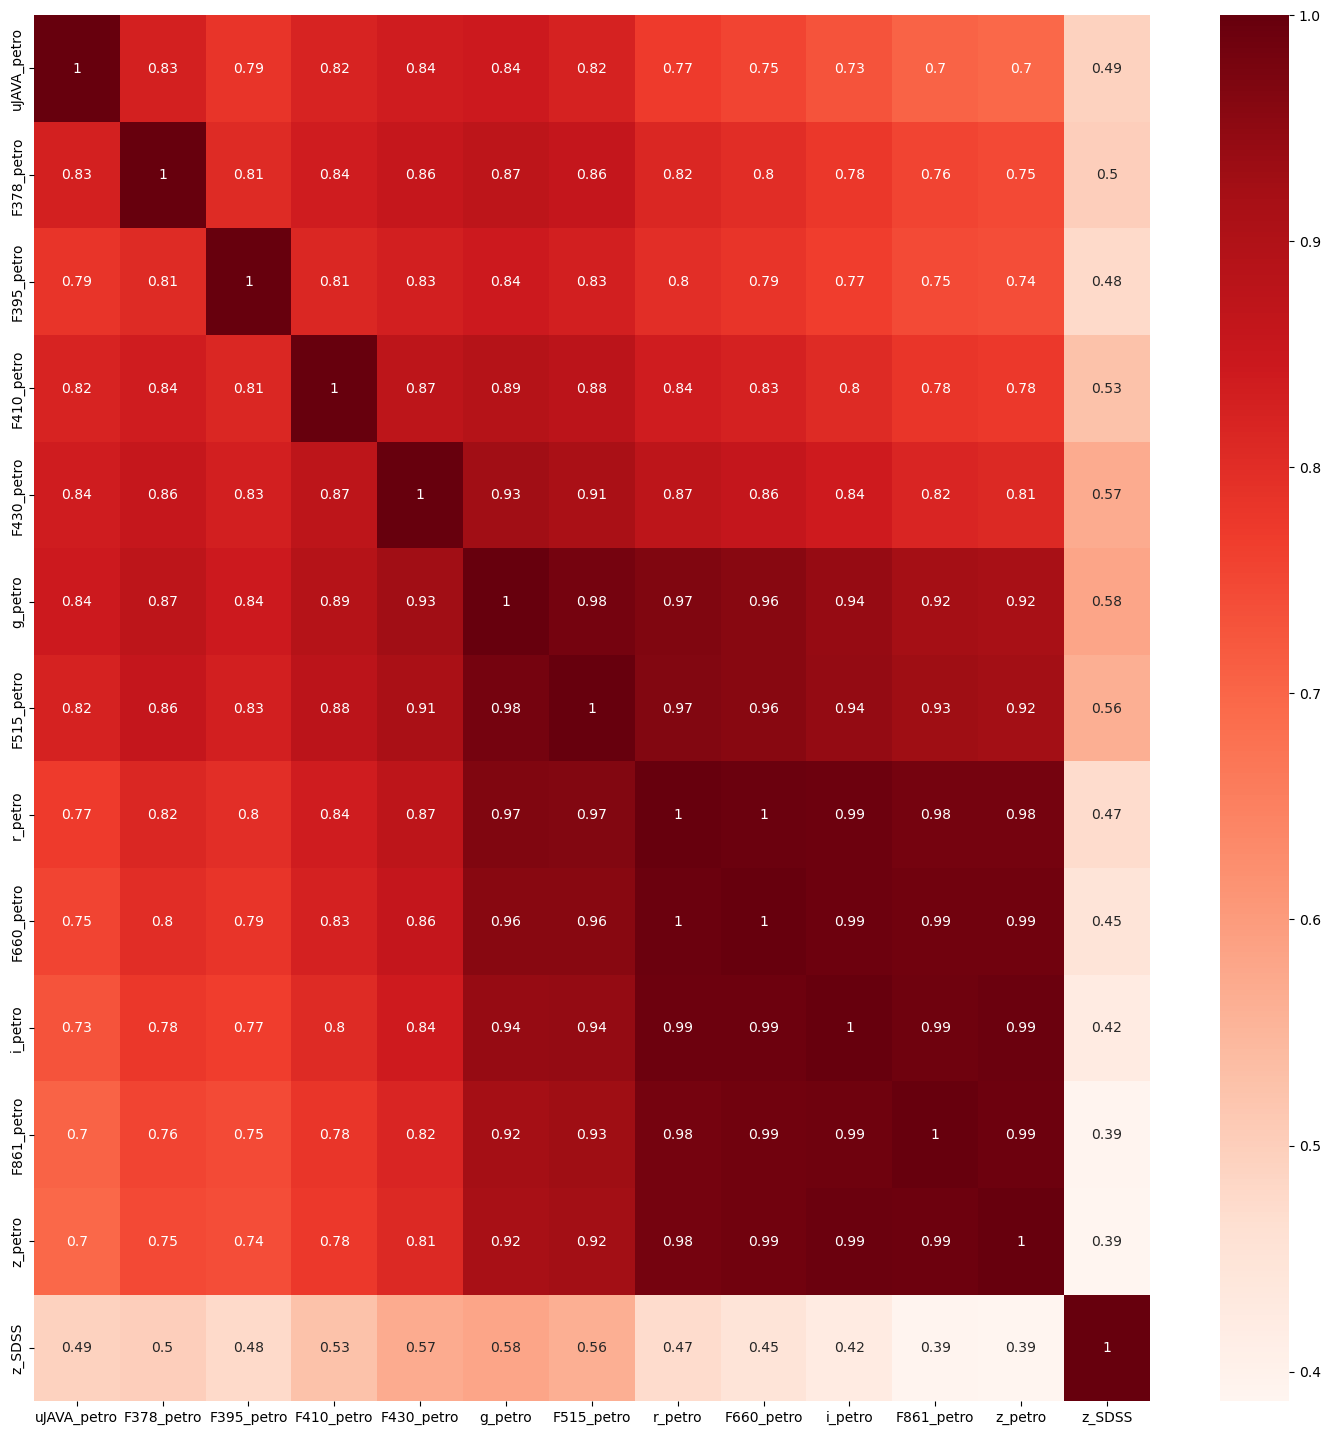

In [124]:
plt.figure(figsize=(18,18))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

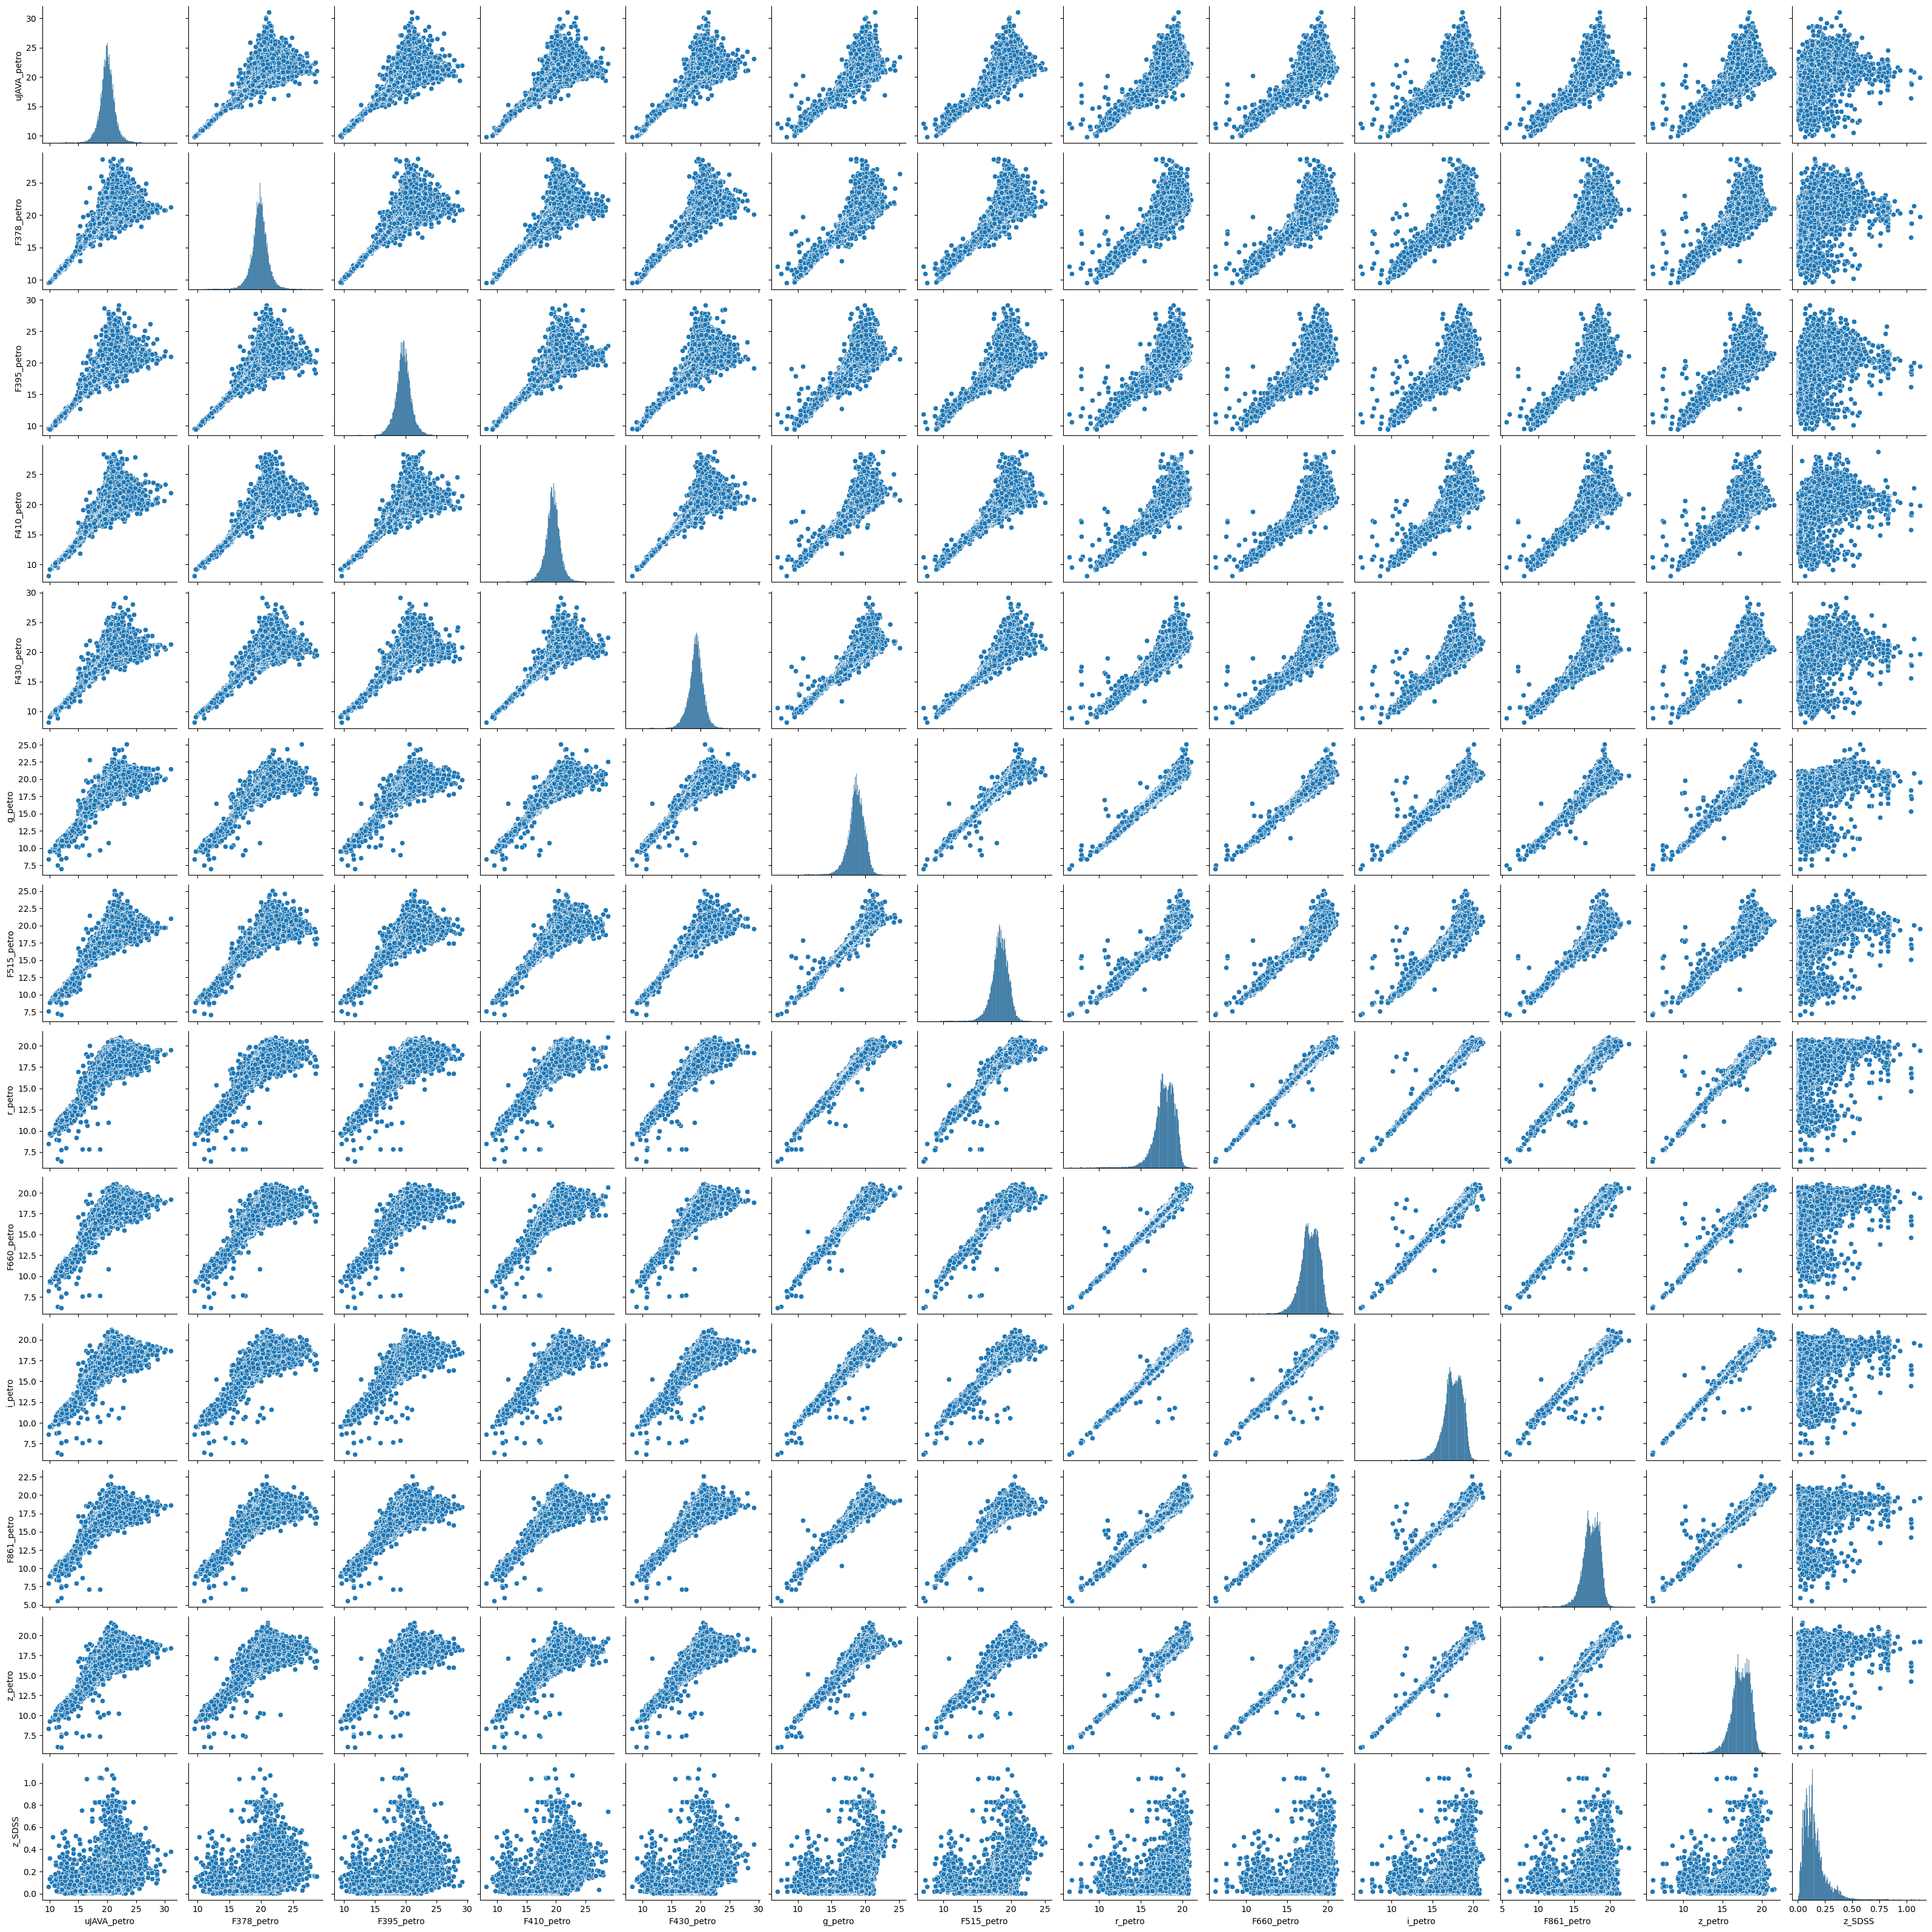

In [125]:
sns.pairplot(df)

## Separemos en Train, Validation y Test.

In [126]:
X = df.drop("z_SDSS", axis=1) # Estas son mis variables predictoras 
y = df["z_SDSS"] #variables target


col_train = X.columns         # aca guardo los nombre de las columnas (features)


################################################ ESTANDARIZO

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #Separo en entrenamiento y testeo



X_train_val, X_validation, y_train_val, y_validation = train_test_split(X_train, y_train, random_state=123) #Separo en entrenamiento y validation


########################################################## Add a constant

#X_validation = sm.add_constant(X_validation)
#X_train_val = sm.add_constant(X_train_val)
#X_test = sm.add_constant(X_test)



In [127]:


X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

# Fitting the scalers and transforming the training sets
X_train_val = X_scaler.fit_transform(X_train_val)
X_validation = X_scaler.fit_transform(X_validation)

y_validation_std = y_scaler.fit_transform(y_validation.to_numpy().reshape(-1,1))
y_train_val_std = y_scaler.fit_transform(y_train_val.to_numpy().reshape(-1,1))

# Transforming the test set
X_test = X_scaler.transform(X_test)



In [165]:
def performance(y_pred_val,y_pred_train,y_validation,y_train_val):
    y_pred_train = y_scaler.inverse_transform(y_pred_train.reshape(-1,1))
    y_pred_val = y_scaler.inverse_transform(y_pred_val.reshape(-1,1))
    print ('MAE for validation:', metrics.mean_absolute_error(y_validation, y_pred_val))
    print ('MSE for validation:', metrics.mean_squared_error(y_validation, y_pred_val))
    print ('RMSE for validation:', np.sqrt(metrics.mean_squared_error(y_validation, y_pred_val)))
    print ('R2 for validation:', metrics.r2_score(y_validation, y_pred_val))

    print ('MAE for train:', metrics.mean_absolute_error(y_train_val, y_pred_train))
    print ('MSE for train:', metrics.mean_squared_error(y_train_val, y_pred_train))
    print ('RMSE for train:', np.sqrt(metrics.mean_squared_error(y_train_val, y_pred_train)))
    print ('R2 for train:', metrics.r2_score(y_train_val, y_pred_train))
    return

## Implement the LR model

In [128]:
# creamos el modelo y fiteamos
lr = LinearRegression()
lr.fit(X_train_val, y_train_val)

# Imprimimos coeficientes
print (lr.intercept_)
print (lr.coef_)

[-0.26071453]
[[-0.32485669 -0.26190226 -0.10097285 -0.14551457  0.14022876  2.37133228
   0.77728179 -0.55337985 -0.25605209  0.30846835 -0.76554513 -0.44266163]]


In [129]:
y_pred_val = lr.predict(X_validation)

y_pred_train = lr.predict(X_train_val)

In [166]:
performance(y_pred_val,y_pred_train,y_validation,y_train_val)

MAE for validation: 0.054963294716068624
MSE for validation: 0.00663016022510158
RMSE for validation: 0.08142579582111298
R2 for validation: 0.33943984224348034
MAE for train: 0.0440933588434976
MSE for train: 0.004358566553089929
RMSE for train: 0.06601944072082049
R2 for train: 0.5257697763767168


- MAE es el error promedio.
- MSE "penaliza" errores grandes.
- RMSE es interpretable, tiene las mismas unidades  que la "y".
- $R^2$ es la proporción de la varianza total de $Y$ explicada por el modelo

Con excepción de R2, todas estas son funciones de pérdida, porque queremos minimizarlas.

### Optimicemos el modelo!

## Ridge

Usaremos 1ro regularizacion por RIDGE, el cual nos determina automaticamente mediante CROSS VALIDATION el alfa optimo.
Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

In [146]:
#ridge_lr = linear_model.Ridge(alpha=0.5, normalize=True).fit(X_train_val, y_train_val)
rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.01,100, 1000), cv=5, normalize=True, scoring='r2')

ridge_lr = rlmcv.fit(X_train_val, y_train_val)

print ("alpha:", rlmcv.alpha_)

y_R_pred_train = ridge_lr.predict(X_train_val)
y_R_pred_val = ridge_lr.predict(X_validation)

alpha: 0.001


In [167]:
performance(y_R_pred_val,y_R_pred_train,y_validation,y_train_val)

MAE for validation: 0.05344867773439682
MSE for validation: 0.006398740044262631
RMSE for validation: 0.07999212488903286
R2 for validation: 0.3624961404282918
MAE for train: 0.04412910437467038
MSE for train: 0.00436083781813587
RMSE for train: 0.0660366399670355
R2 for train: 0.5255226532646744


## Ahora usamos LASSO

In [135]:
#lasso_lr = linear_model.Lasso(alpha=0.5, normalize=True).fit(X_train_val, y_train_val)

lassocv = linear_model.LassoCV(alphas=np.linspace(0.01,100, 5000), cv=5, normalize=True)

lasso_lr = lassocv.fit(X_train_val, y_train_val)

print ("alpha:", lassocv.alpha_)

y_L_pred_train = lasso_lr.predict(X_train_val)
y_L_pred_val = lasso_lr.predict(X_validation)

alpha: 100.0


In [168]:
performance(y_L_pred_val,y_L_pred_train,y_validation,y_train_val)

MAE for validation: 0.07343556910117696
MSE for validation: 0.010050357211705089
RMSE for validation: 0.1002514698730402
R2 for validation: -0.0013129879031807956
MAE for train: 0.07109413558001161
MSE for train: 0.009190824068084425
RMSE for train: 0.09586878568170365
R2 for train: 0.0


# Random forest Regression

Firstly we most find the hyperparameters such that optimize the performance.

In [150]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
RF = RandomForestRegressor(random_state=0)

clf = GridSearchCV(RF, parameters)
clf.fit(X_train_val, y_train_val)

y_RF_pred_val = clf.predict(X_validation)
y_RF_pred_train = clf.predict(X_train_val)






In [170]:
performance(y_RF_pred_val, y_RF_pred_train , y_validation, y_train_val)

MAE for validation: 0.06701972627376988
MSE for validation: 0.007123729197040224
RMSE for validation: 0.08440218715791803
R2 for validation: 0.2902657669725439
MAE for train: 0.0470416993799345
MSE for train: 0.004307046197102017
RMSE for train: 0.06562809000041078
R2 for train: 0.5313754060358482


In [144]:
results = pd.DataFrame(zip(y_validation, y_RF_pred_val, y_validation - y_RF_pred_val), columns = ['y_Validation', 'y_pred', 'error'])
results.head(10)

y_Validation    y_pred  \
0   [0.2879227053140097]  0.262222   
1   [0.1033816425120773]  0.166438   
2  [0.14589371980676327]  0.166438   
3  [0.14589371980676327]  0.152912   
4  [0.07053140096618359]  0.061514   
5   [0.1758454106280193]  0.166438   
6  [0.10434782608695653]  0.166438   
7  [0.05120772946859904]  0.072987   
8  [0.04734299516908213]  0.159048   
9  [0.10048309178743962]  0.123601   

                                               error  
0  [0.025700835930112576, 0.12148490646339927, 0....  
1  [-0.1588402268718198, -0.06305615633853313, -0...  
2  [-0.11632814957713386, -0.02054407904384717, -...  
3  [-0.11632814957713386, -0.02054407904384717, -...  
4  [-0.19169046841771353, -0.09590639788442686, -...  
5  [-0.08637645875587782, 0.00940761177740887, 0....  
6  [-0.1578740432969406, -0.06208997276365391, -0...  
7  [-0.2110141399152981, -0.1152300693820114, -0....  
8  [-0.214878874214815, -0.1190948036815283, -0.1...  
9  [-0.1617387775964575, -0.06595470706317082, -0...

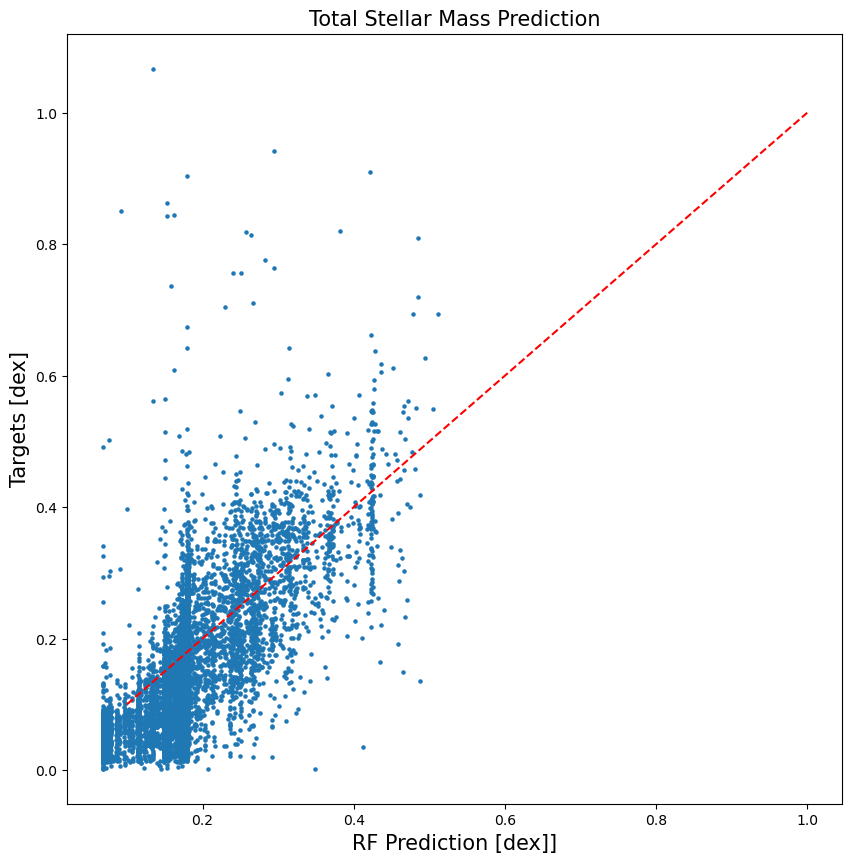

In [155]:
# Plotting a predict plot
plt.figure(figsize=(10,10))
plt.scatter(y_RF_pred_val, y_validation, s=5)
plt.plot([0.1,1],[0.1,1],'r--')
plt.title("Total Stellar Mass Prediction", fontsize=15)
plt.xlabel("RF Prediction [dex]]", fontsize=15)
plt.ylabel("Targets [dex]", fontsize=15)
plt.show()

## xgboost 

In [162]:
PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
               "min_child_weight":[1, 5],
               "learning_rate":[0.1, 0.01]}

xgb_r= xgb.XGBClassifier(n_estimators=100, n_jobs=-1, eval_metric='logloss',early_stopping_rounds=10)

model_xgr = GridSearchCV(estimator=estimator,param_grid=PARAMETERS,cv=3,scoring="neg_log_loss")

model_xgr.fit(X_train,y_train,eval_set=eval_set,verbose=0)

# print out the best hyperparameters
print(model.best_params_)

NameError: name 'xgb' is not defined